In [1]:
from typing import Dict, List, Tuple, Union

import pandas as pd
import qlib
from qlib.data import D
from qlib.data.filter import NameDFilter
from FactorZoo import SportBettingFactor
from src.build_factor import get_factors_frame

In [2]:
qlib.init(provider_uri="data/qlib_data", region="cn")

[16652:MainThread](2023-06-27 20:53:45,376) INFO - qlib.Initialization - [config.py:416] - default_conf: client.
[16652:MainThread](2023-06-27 20:53:46,225) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[16652:MainThread](2023-06-27 20:53:46,226) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': WindowsPath('D:/WorkSpace/Quantitative-analysis/B-因子构建类/个股动量效应的识别及“球队硬币”因子/data/qlib_data')}


In [3]:
# 进获取A股所有股票 qlib过滤器速度很慢 不如手动过滤
POOLS: List = D.list_instruments(
    D.instruments("CN", filter_pipe=[NameDFilter("(3|6|0)\d{5}\.(SH|SZ)")]),
    as_list=True,
)

data: pd.DataFrame = D.features(
    POOLS, fields=["$close", "$open", "$turnover_rate", "$turnover_rate_f"]
)
data.columns = data.columns.str.replace("$", "",regex=True)

In [4]:
factors_frame: pd.DataFrame = get_factors_frame(
    data, 20, general_names=["interday", "intraday", "overnitht"]
)

NameError: name 'Union' is not defined

In [9]:
ls = []

for i in ['interday','intraday']:
    
    ls.extend([f"{i}_volatility_reverse",f"{i}_turnover_reverse",f"revise_{i}_reverse"])

In [10]:
ls

['interday_volatility_reverse',
 'interday_turnover_reverse',
 'revise_interday_reverse',
 'intraday_volatility_reverse',
 'intraday_turnover_reverse',
 'revise_intraday_reverse']

In [5]:
# 获取因子名称
factor_type: set = {"interday", "intraday", "overnight"}
volatility_reverse: List = [f"{i}_volatility_reverse" for i in factor_type]
turnover_reverse: List = [f"{i}_turnover_reverse" for i in factor_type]
revise_interday: List = [f"revise_{i}_reverse" for i in factor_type]
factors: List = volatility_reverse + turnover_reverse + revise_interday
# 计算因子
factors_df: pd.DataFrame = pd.concat(
    (getattr(sportbetting, factor_name)(window=20, method=1, usedf=False) for factor_name in factors),
    axis=1,
)

<Axes: xlabel='datetime'>

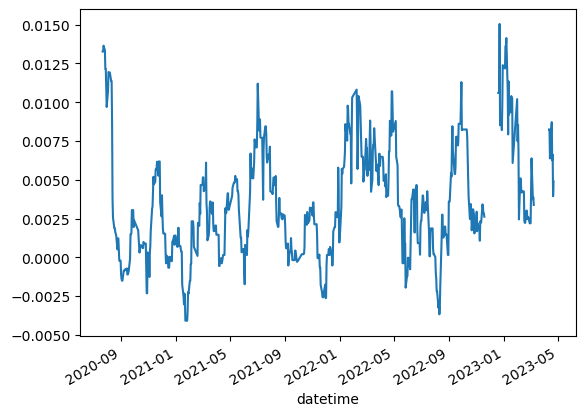